# Summary

This project performs a market basket analysis (MBA) on a set of data from a UK based non-store online retail agency. 
The goal is to find the most purchased items for a VIP group and to find the items which are usually purchased together.The results obtained can be utilized for marketing purposes. The VIP selection is based on the purchasing score of costumers.

The data is obtained from UCI Machine Learning Repository. To be completed.


In [1]:
# importing libraries
import sys
import numpy as np
import sklearn 
import pandas as pd
import matplotlib

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [2]:
# printing the version of libraries

print('python: {}'.format(sys.version))
print('numpy: {}'.format(np.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('panda: {}'.format(pd.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))

python: 3.6.1 (v3.6.1:69c0db5, Mar 21 2017, 17:54:52) [MSC v.1900 32 bit (Intel)]
numpy: 1.13.0
sklearn: 0.20.3
panda: 0.24.2
matplotlib: 2.1.2


In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [4]:
# reading data 
file_path="./OnlineRetail.csv"
data = pd.read_csv(file_path,encoding='latin1')
data=data[0:10000]
print(data.shape)
print(type(data))


(10000, 8)
<class 'pandas.core.frame.DataFrame'>


In [5]:
# seeing data columns
data.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
5  12/1/2010 8:26       7.65     17850.0  United Kingdom  
6  12/1/2010 8:26       4.25     17850.0  United Kingdom  
7  12/1/2010 8:28       1.85     17850.0  United Kingdom  
8  12/1/2010 8:28       1.85     17850.0  United Kingdom  
9  12/1/2010 8:34       1.69     13047.0  United Kingdom

In [6]:
data.describe()


Quantity     UnitPrice    CustomerID
count  10000.000000  10000.000000   7709.000000
mean       7.828600      3.837412  15615.462576
std      104.322417     14.310148   1756.540802
min    -9360.000000      0.000000  12395.000000
25%        1.000000      1.250000  14388.000000
50%        2.000000      2.510000  15605.000000
75%        8.000000      4.210000  17228.000000
max     2880.000000    887.520000  18239.000000

In [7]:
# removing spaced from description items 
data['Description'] = data['Description'].str.strip()


In [8]:
# removing rows with negative quantity, or negative price, or nan

data=data.dropna(how='any') 
data = data.loc[(data['UnitPrice'] >= 0) & (data['Quantity'] >= 0) ]


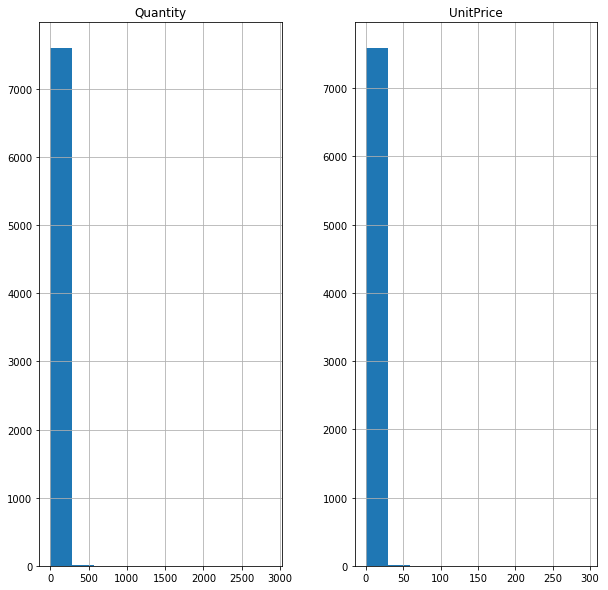

In [9]:
#histogram of quantity and unit price
plt.rcParams['figure.figsize'] = [10,10]
data.hist(column=['Quantity','UnitPrice'],bins=10)
plt.show()

In [10]:
# spending score

unique_cstmrs=[]
for costumer in data.iloc[:,6]:
    if costumer not in unique_cstmrs:
        unique_cstmrs.append(costumer)
        
len(unique_cstmrs)

303

In [11]:
spend_lst=[]
for unique_cstmr in unique_cstmrs:
    spend=0
    for n in range(len(data)):
            if data.iloc[n,6]==unique_cstmr:
                spend=data.iloc[n,3]*data.iloc[n,5]+spend
    spend_lst.append([unique_cstmr,spend])
    
data_spend=pd.DataFrame(spend_lst,columns=['CustomerID','SpendScore'])


In [12]:
print(data_spend.head())

   CustomerID  SpendScore
0     17850.0     5391.21
1     13047.0      366.63
2     12583.0      855.86
3     13748.0      204.00
4     15100.0      350.40


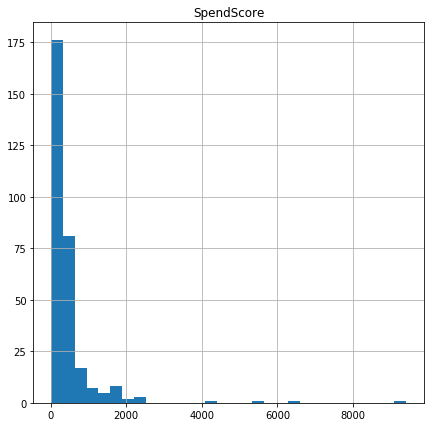

count     303.000000
mean      489.131452
std       828.831600
min        15.000000
25%       188.405000
50%       301.240000
75%       434.775000
max      9407.340000
Name: SpendScore, dtype: float64

In [13]:
#histogram of costumer spend
plt.rcParams['figure.figsize'] = [7,7]
data_spend.hist(column=['SpendScore'],bins=30)
plt.show()
data_spend.SpendScore.describe()


In [14]:
# defining vip list:  the data is right skewed so median is used as a measure to select vips
vip_list=[]
data_spend.SpendScore.median()
for n in range(len(data_spend)):
    if data_spend.SpendScore[n]>0: #(data_spend.SpendScore.median()):
        vip_list.append(data_spend.CustomerID[n])
len(vip_list)

303

In [15]:
# getting all data for VIPs
prchs_vips=[]
for n in range(len(data.CustomerID)):
    if data.iloc[n,6] in vip_list:
        prchs_vips.append(data.iloc[n,:])
len(prchs_vips)
df_prchs_vips=pd.DataFrame(prchs_vips,columns=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country'])
df_prchs_vips.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
5  12/1/2010 8:26       7.65     17850.0  United Kingdom  
6  12/1/2010 8:26       4.25     17850.0  United Kingdom  
7  12/1/2010 8:28       1.85     17850.0  United Kingdom  
8  12/1/2010 8:28       1.85     17850.0  United Kingdom  
9  12/1/2010 8:34       1.69     13047.0  United Kingdom

In [16]:
# getting all purchased items for a vip costumer 
df_purchase=pd.DataFrame([])
prchs_list=[]
cnt=-1
for cost_id in vip_list:
    lst1=[]
    for n in range(len(df_prchs_vips)):  
        if (df_prchs_vips.iloc[n,6]==cost_id):
            lst1.append(df_prchs_vips.iloc[n,1])
    prchs_list.append(lst1)
len(lst1)

89

In [17]:
#prchs_list[0:2]

In [20]:
te = TransactionEncoder()
te_ary = te.fit(prchs_list).transform(prchs_list)

df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

frequent_itemsets

support        itemsets
0   0.128713         (22086)
1   0.118812         (22423)
2   0.122112         (22632)
3   0.115512         (22633)
4   0.151815         (22865)
5   0.141914         (22866)
6   0.115512         (22867)
7   0.125413         (22910)
8   0.112211         (22961)
9   0.108911        (85123A)
10  0.102310  (22865, 22866)

In [21]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

antecedents consequents  antecedent support  consequent support  support  \
0     (22865)     (22866)            0.151815            0.141914  0.10231   
1     (22866)     (22865)            0.141914            0.151815  0.10231   

   confidence      lift  leverage  conviction  
0    0.673913  4.748736  0.080766    2.631463  
1    0.720930  4.748736  0.080766    3.039329

In [ ]:
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.7) ]